In [1]:
from matplotlib import pyplot as plt
import torch
from torchvision.utils import make_grid
from flow_matching.supervised.alphas_betas import LinearAlpha, LinearBeta
from flow_matching.supervised.samplers import MNISTSampler
from flow_matching.supervised.prob_paths import GaussianConditionalProbabilityPath
from flow_matching.supervised.models import MNISTUNet
from flow_matching.supervised.odes_sdes import CFGVectorFieldODE
from flow_matching.supervised.simulators import EulerSimulator

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Initialize probability path
path = GaussianConditionalProbabilityPath(
    p_data=MNISTSampler(),
    p_simple_shape=[1, 32, 32],
    alpha=LinearAlpha(),
    beta=LinearBeta(),
).to(device)

# Initialize model
unet = MNISTUNet(
    channels=[16, 32, 64],  # [32, 64, 128],
    num_residual_layers=2,
    t_embed_dim=8,  # 40,
    y_embed_dim=8,  # 40,
).to(device)

unet.load_state_dict(torch.load("unet.pt"))

<All keys matched successfully>

100%|██████████| 9/9 [00:01<00:00,  6.99it/s]


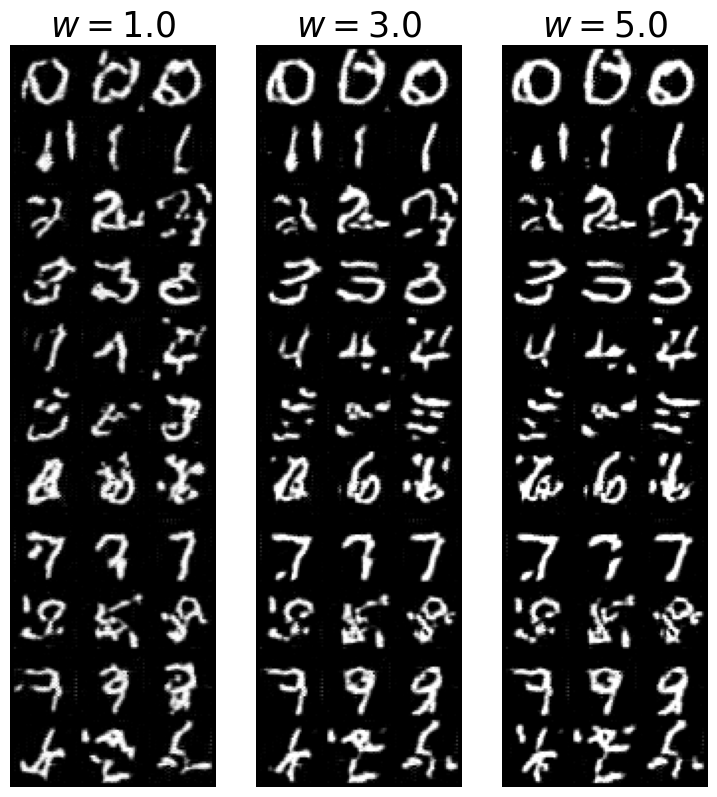

In [12]:
# Play with these!
samples_per_class = 3  # 10
num_timesteps = 10
guidance_scales = [1.0, 3.0, 5.0]

fig, axes = plt.subplots(
    1, len(guidance_scales), figsize=(samples_per_class * len(guidance_scales), 10)
)

# Sample initial conditions
y = (
    torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype=torch.int64)
    .repeat_interleave(samples_per_class)
    .to(device)
)
num_samples = y.shape[0]
x0, _ = path.p_simple.sample(num_samples)  # (num_samples, 1, 32, 32)

for idx, w in enumerate(guidance_scales):
    # Setup ode and simulator
    ode = CFGVectorFieldODE(unet, guidance_scale=w)
    simulator = EulerSimulator(ode)

    # Simulate
    ts = (
        torch.linspace(0, 1, num_timesteps)
        .view(1, -1, 1, 1, 1)
        .expand(num_samples, -1, 1, 1, 1)
        .to(device)
    )
    x1 = simulator.simulate(x0, ts, y=y)

    # Plot
    grid = make_grid(x1, nrow=samples_per_class, normalize=True, value_range=(-1, 1))
    axes[idx].imshow(grid.permute(1, 2, 0).cpu(), cmap="gray")
    axes[idx].axis("off")
    axes[idx].set_title(f"$w={w:.1f}$", fontsize=25)
plt.show()